# Imports

In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import matplotlib as mpl
import numpy as np
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

# Loading iris

In [2]:
iris = load_iris()

Reducing to 2 dimensions for visualizations later

In [3]:
iris_2d = PCA(n_components=2).fit_transform(iris.data[:,:])

# Clustering using a genetic algorithm

### Main class

In [4]:
class GAC:
    samples = []
    def __init__(self, X):
        GAC.samples = X
        
        # Used to keep iteration count for display (not used in operators)
        self.GEN_COUNT = 0

        #
        self.latest_25 = [1]*25

        # Used by the mutation operator.
        # Gives a chance to mutate between 1 and 10 times, with odds proportional to inverse squared.
        # By changing the power of 'i' from 2 to a higher number, odds of mutation can be significantly lowered -
        # and therefore the evolution made much more stable. However, convergence might also become extremely slow.
        # A power of 2 seems to give good results so it was kept.
        self.MUTATION_CHANCE_SUM = np.sum([1/(i**2) for i in range(1,11)])
        self.MUTATION_PROBABILITY = [(1/(i**2))/self.MUTATION_CHANCE_SUM for i in range(1,11)]

    def evolveUntilThreshold(self, initial_pop, threshold = 0.01):
        evolving_pop = initial_pop
        
        average_change = sum(self.latest_25)/len(self.latest_25)
        # Threshold is percentage of maximum fitness to try and reach.
        while average_change > threshold:
            
            self.GEN_COUNT += 1
    
            # Print the fitness of the fittest individual within population once every 100 generations.
            if self.GEN_COUNT % 100 == 0:
                print(f'Generation {self.GEN_COUNT}, fitness of the fittest individual: {evolving_pop.fittest_score}\nAverage change over last 25 gens: {average_change}')

            generational_change = -evolving_pop.fittest_score
            evolving_pop = self.generateNextGen(evolving_pop)
            generational_change += evolving_pop.fittest_score
            generational_change /= evolving_pop.fittest_score
            self.latest_25.pop(0)
            self.latest_25.append(abs(generational_change))
            average_change = sum(self.latest_25)/len(self.latest_25)
        
        print("\n --- Convergence finished ---")
        print(f"Final fitness: {evolving_pop.fittest_score}")
        return evolving_pop
    
    def generateNextGen(self, population):
        # Probability of an individual being chosen as a parent, proportional to their fitness.
        total_sum = sum(indv.fitness for indv in population.individuals)
        selection_probabilities = [indv.fitness/total_sum for indv in population.individuals]

        next_gen_indv_list = []
        
        while len(next_gen_indv_list) < population.size:
            # Choose two parents using previously defined probabilities. 
            # Same individual can effectively be chosen twice and hence become "both" parents of its offspring.
            par1, par2 = np.random.choice(population.individuals, size=2, p=selection_probabilities)
            offspring1, offspring2 = GAC.Selection.crossover(par1, par2)
            
            # Mutate the offspring according to the probability matrix defined in '__init__'.
            # Most likely scenario is no mutation at all.
            for _ in range(np.random.choice(range(10), p=self.MUTATION_PROBABILITY)):
                GAC.Selection.mutate(offspring1)

            for _ in range(np.random.choice(range(10), p=self.MUTATION_PROBABILITY)):
                GAC.Selection.mutate(offspring2)

            offspring1.calculateFitness()
            offspring2.calculateFitness()

            # Add offspring to list of the next generation.
            next_gen_indv_list.extend([offspring1, offspring2])

        # Sort the population by fitness.
        next_gen_indv_list.sort(key=lambda indv: indv.fitness, reverse=True)

        return GAC.Population(next_gen_indv_list)
    
    # The fitness function is simply the Calinski-Harabasz score for that clustering (chromosome).
    def fitness(indv):
        return metrics.calinski_harabasz_score(GAC.samples, indv.chromosome)
    
    class Selection:
        
        # Simple point mutation
        def mutate(indv):
            idx = np.random.randint(low=0,high=150)
            val = np.random.randint(low=0,high=3)
            indv.chromosome[idx] = val
            return indv
        
        # Simple random slice crossover operator
        def crossover(par1, par2):
            slice_point = np.random.randint(low=0,high=150)
            offspring1 = GAC.Individual([*par1.chromosome[0:slice_point], *par2.chromosome[slice_point:]], False)
            offspring2 = GAC.Individual([*par2.chromosome[0:slice_point], *par1.chromosome[slice_point:]], False)

            return offspring1, offspring2
        
    class Population:
        def __init__(self, indv_list):
            self.individuals = indv_list
            self.fittest = self.individuals[0]
            self.fittest_score = self.individuals[0].fitness
            self.size = len(self.individuals)
        def initialize(n=50):
            individual_list = [GAC.Individual(np.random.randint(low=0,high=3, size=150)) for _ in range(n)]
            individual_list.sort(key=lambda indv: indv.fitness, reverse=True)
            return GAC.Population(individual_list)

    class Individual:
        def __init__(self, chromosome, calc_fitness = True):
            self.chromosome = chromosome
            if calc_fitness: self.fitness = GAC.fitness(self)
            else: self.fitness = 0
        def calculateFitness(self):
            self.fitness = GAC.fitness(self)
        def __str__(self) -> str:
            return str(self.fitness)
        def __repr__(self) -> str:
            return self.__str__()

# Clustering using the Genetic Algorithm

In [5]:
ga = GAC(iris.data[:,:])

An initial population size of 200 seems to work best. A population size of 250 or greater seems to slow down the algorithm's convergence while a population size of 100 makes the algorithm too volatile. The optimal initial population size is heavily dependent on the mutation probability matrix. The likelier mutations are, the better it is to have larger populations.

In [6]:
initial_pop = GAC.Population.initialize(n=200)

In [7]:
soln = ga.evolveUntilThreshold(initial_pop, 0.01)

Generation 100, fitness of the fittest individual: 107.47404058913756
Average change over last 25 gens: 0.05090695446244679
Generation 200, fitness of the fittest individual: 258.90847677141437
Average change over last 25 gens: 0.038808007012918186
Generation 300, fitness of the fittest individual: 362.430507250597
Average change over last 25 gens: 0.036576458577513044
Generation 400, fitness of the fittest individual: 378.65122902020516
Average change over last 25 gens: 0.014955743028261718
Generation 500, fitness of the fittest individual: 366.22673210964035
Average change over last 25 gens: 0.02085810187979363
Generation 600, fitness of the fittest individual: 458.0422553664609
Average change over last 25 gens: 0.019310918476570373
Generation 700, fitness of the fittest individual: 432.72841260429993
Average change over last 25 gens: 0.020881924328532177

 --- Convergence finished ---
Final fitness: 451.11524756235576


# Clustering using K-Means

In [8]:
labels_km = KMeans(n_clusters=3, n_init='auto').fit_predict(iris.data)

# Evaluation of clustering quality

Renaming of clusters such that they match class names. This will allow clearer plotting and also enables us to calculate more metrics.

In [9]:
# Change [0] to another number to get the labels for a different individual.
# Since the individuals are sorted by fitness, soln.individuals[1] will for example return the second fittest individual.
labels_ga = np.array(soln.individuals[0].chromosome)
matched_labels_ga = np.zeros(shape=150, dtype=int)
cluster0 = Counter(labels_ga[0:50])
cluster1 = Counter(labels_ga[50:100])
cluster2 = Counter(labels_ga[100:150])
matched_labels_ga[labels_ga == max(cluster0, key=cluster0.get)] = 0
matched_labels_ga[labels_ga == max(cluster1, key=cluster1.get)] = 1
matched_labels_ga[labels_ga == max(cluster2, key=cluster2.get)] = 2

In [10]:
matched_labels_km = np.zeros(shape=150, dtype=int)
cluster0 = Counter(labels_km[0:50])
cluster1 = Counter(labels_km[50:100])
cluster2 = Counter(labels_km[100:150])
matched_labels_km[labels_km == max(cluster0, key=cluster0.get)] = 0
matched_labels_km[labels_km == max(cluster1, key=cluster1.get)] = 1
matched_labels_km[labels_km == max(cluster2, key=cluster2.get)] = 2

### Classification report for KMeans Clustering

In [11]:
print(metrics.classification_report(iris.target, matched_labels_km))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.77      0.94      0.85        50
           2       0.92      0.72      0.81        50

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



### Classification report for Genetic Clustering

In [12]:
print(metrics.classification_report(iris.target, matched_labels_ga))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.78      0.80      0.79        50
           2       0.80      0.78      0.79        50

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.86      0.86      0.86       150



### Clusters visualized

<Figure size 1280x960 with 0 Axes>

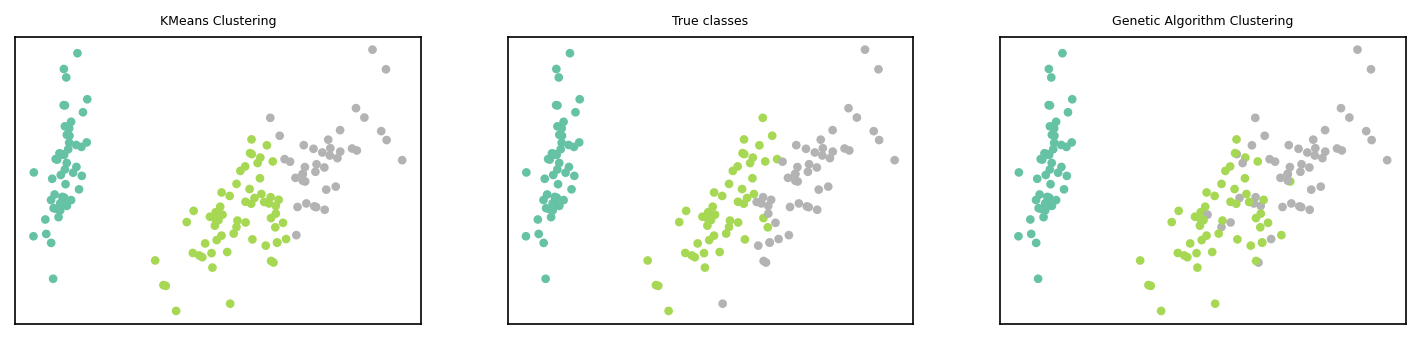

In [15]:
mpl.rcParams['axes.titlesize'] = 6
fig = plt.figure()
fig.set_dpi(200)
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(10,2.5)
fig.tight_layout()
ax1, ax3, ax2 = ax

ax1.scatter(iris_2d[:, 0], iris_2d[:, 1], c=matched_labels_km, cmap='Set2', s=10)
ax2.scatter(iris_2d[:, 0], iris_2d[:, 1], c=matched_labels_ga, cmap='Set2', s=10)
ax3.scatter(iris_2d[:, 0], iris_2d[:, 1], c=iris.target, cmap='Set2', s=10)

ax1.set_title("KMeans Clustering")
ax1.tick_params(left = False, bottom = False)
ax1.set(xticklabels=[],yticklabels=[])

ax2.set_title("Genetic Algorithm Clustering")
ax2.tick_params(left = False, bottom = False)
ax2.set(xticklabels=[],yticklabels=[])

ax3.set_title("True classes")
ax3.tick_params(left = False, bottom = False)
ax3.set(xticklabels=[],yticklabels=[])
pass